In [42]:
!pip install country_converter



#Data Analysis 
import pandas as pd
from pandas import Series
import numpy as np
import re
import country_converter as coco


#Data Vis
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk



#Data Vis setting
%matplotlib inline
sns.set_theme(style="dark")
# mpl.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-dark-palette')
plt.style.use('dark_background')


# 1. Data Manipulation &  Data Cleaning

In [43]:
df = pd.read_csv("titles.csv")
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [44]:
df.drop(columns={"description","imdb_id","id"},inplace=True)

Remove unnecessary columns from the dataset.

Handle with the [''] in genres and production_countries before handling missing value in case of Pandas identifies an empty [] as an value.

In [45]:
repalce_list = ["[","'","]"]
for i in repalce_list:
    for x in ["genres","production_countries"]:
        df[x] = df[x].str.replace(i,'',regex=True)

In [46]:
# for x in ["genres","production_countries"]:
#     df[x] = df[x].str.findall(r"'(.+?)'").replace('')
    # df[x] = df[x].str.findall(r"[(.+?)]").replace('')

Text(0.5, 1.0, 'Missing Values Matrix')

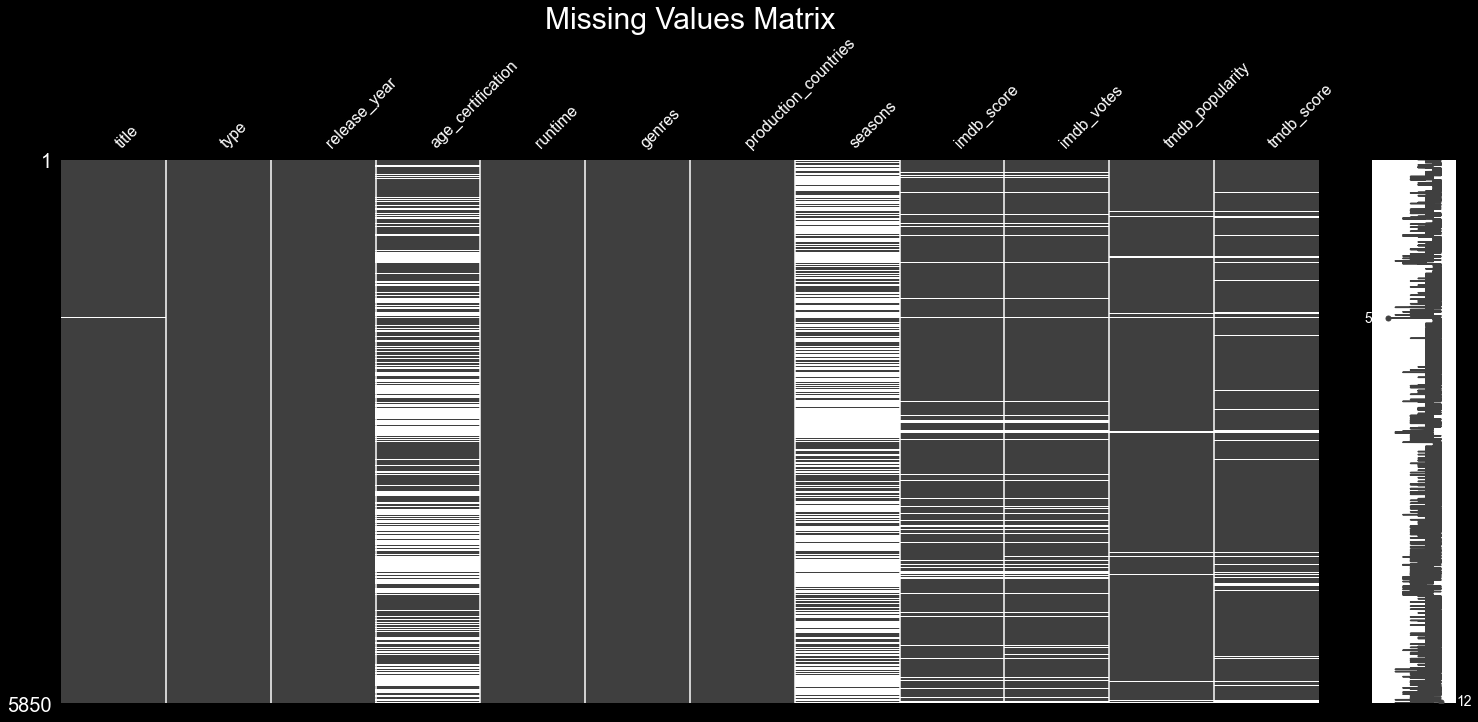

In [47]:
msno.matrix(df)
plt.title("Missing Values Matrix",fontsize=30)

In [48]:
df.isnull().sum()

title                      1
type                       0
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64

In [49]:
df = df.drop(df[df["title"].isnull()].index) #There is a rows that shows NaN but can not be removed using dropna, so I decided to drop the rows directly

In [50]:
print(df["age_certification"].unique()) #I found that the age_certification includes all of the age rating on Netfilx, so I believe that those missing value is stands for Not Rated
df["age_certification"].fillna("Not Rated",inplace=True)

['TV-MA' 'R' 'PG' nan 'TV-14' 'PG-13' 'TV-PG' 'TV-Y' 'TV-G' 'TV-Y7' 'G'
 'NC-17']


In [51]:
df[df["seasons"].isnull()]["type"].value_counts()

MOVIE    3743
Name: type, dtype: int64

In [52]:
df["type"].value_counts()

MOVIE    3743
SHOW     2106
Name: type, dtype: int64

I found that all of the missing values in season colunms come from the data with type of "movie", so I decided to fill it with 0 instead of drop them off.

In [53]:
df["seasons"].fillna(0,inplace=True)

In [54]:
for i in ["imdb_score","imdb_votes","tmdb_popularity","tmdb_score"]:
    df[i] = df[i].fillna(np.mean(df[i]))

In [55]:
df.head()

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,Five Came Back: The Reference Films,SHOW,1945,TV-MA,51,documentation,US,1.0,6.510861,23439.382474,0.600,6.829175
1,Taxi Driver,MOVIE,1976,R,114,"drama, crime",US,0.0,8.200000,808582.000000,40.965,8.179000
2,Deliverance,MOVIE,1972,R,109,"drama, action, thriller, european",US,0.0,7.700000,107673.000000,10.010,7.300000
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"fantasy, action, comedy",GB,0.0,8.200000,534486.000000,15.461,7.811000
4,The Dirty Dozen,MOVIE,1967,Not Rated,150,"war, action","GB, US",0.0,7.700000,72662.000000,20.398,7.600000


# 2.Catagorical Analysis

2.1:Type analysis

In [56]:
type_count = df["type"].value_counts()

type_fig = px.pie(values=type_count.values,names=type_count.index,color_discrete_sequence=px.colors.sequential.Teal,template="plotly_dark",title="Type Distribution")
type_fig.update_traces(textinfo='label+percent+value', textfont_size=12,marker=dict(line=dict(color='gray', width=1.5)))
type_fig.show()

In this dataset, 36% data is Show and 64% data is Movie

2.2 Age Certification analysis

In [57]:
df["age_certification"].unique()

array(['TV-MA', 'R', 'PG', 'Not Rated', 'TV-14', 'PG-13', 'TV-PG', 'TV-Y',
       'TV-G', 'TV-Y7', 'G', 'NC-17'], dtype=object)

In [58]:
df[df["age_certification"]=="Other"]

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score


In [59]:
df[df["age_certification"]!="Other"]

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,Five Came Back: The Reference Films,SHOW,1945,TV-MA,51,documentation,US,1.0,6.510861,23439.382474,0.600000,6.829175
1,Taxi Driver,MOVIE,1976,R,114,"drama, crime",US,0.0,8.200000,808582.000000,40.965000,8.179000
2,Deliverance,MOVIE,1972,R,109,"drama, action, thriller, european",US,0.0,7.700000,107673.000000,10.010000,7.300000
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"fantasy, action, comedy",GB,0.0,8.200000,534486.000000,15.461000,7.811000
4,The Dirty Dozen,MOVIE,1967,Not Rated,150,"war, action","GB, US",0.0,7.700000,72662.000000,20.398000,7.600000
...,...,...,...,...,...,...,...,...,...,...,...,...
5845,Fine Wine,MOVIE,2021,Not Rated,100,"romance, drama",NG,0.0,6.800000,45.000000,1.466000,6.829175
5846,C/O Kaadhal,MOVIE,2021,Not Rated,134,drama,,0.0,7.700000,348.000000,22.637925,6.829175
5847,Lokillo,MOVIE,2021,Not Rated,90,comedy,CO,0.0,3.800000,68.000000,26.005000,6.300000
5848,Dad Stop Embarrassing Me - The Afterparty,MOVIE,2021,PG-13,37,,US,0.0,6.510861,23439.382474,1.296000,10.000000


In [60]:
age_count = df["age_certification"].value_counts()
age_fig = px.bar(y=age_count.values,x=age_count.index,text=age_count.values,title="Age Certification Distribution",color_discrete_sequence=px.colors.sequential.Teal,template="plotly_dark")
age_fig.update_layout(xaxis_title="Age Certification",yaxis_title="Count")
age_fig.show()

In [61]:
df["genres"]

0                           documentation
1                            drama, crime
2       drama, action, thriller, european
3                 fantasy, action, comedy
4                             war, action
                      ...                
5845                       romance, drama
5846                                drama
5847                               comedy
5848                                     
5849            family, animation, comedy
Name: genres, Length: 5849, dtype: object

2.3 Genres analysis

In [62]:
genres = []

for i in df['genres']:
    for s in i.split(","):
        s = s.lower().strip()
        genres.append(s)

genres = [x for x in genres if x]#remove empty string in the counter
top_10_genres = pd.Series(genres).value_counts()[:10]
top_10_genres

drama            2968
comedy           2325
thriller         1228
action           1157
romance           971
documentation     952
crime             936
animation         705
family            682
fantasy           630
dtype: int64

In [63]:
genres_percentage = [(i / len(genres)).round(4) for i in top_10_genres.values]
genres_percentage

[0.1967, 0.1541, 0.0814, 0.0767, 0.0644, 0.0631, 0.062, 0.0467, 0.0452, 0.0418]

In [64]:
genres_fig = px.bar(y=top_10_genres.values,x=top_10_genres.index,text=top_10_genres,title="Top 10 Genres",color_discrete_sequence=px.colors.sequential.Teal,template="plotly_dark")
genres_fig.update_layout(xaxis_title="Genres",yaxis_title="Count")
genres_fig.show()

#what if i dont save the file??

2.4 Production Counties analysis

In [65]:
country_list = []
for i in df["production_countries"]:
    for s in i.split(","):
        s = s.strip()
        country_list.append(s)

pd.Series(country_list).unique()
country_list = [i.replace("Lebanon","LB") for i in country_list]
 # I found that there is a wrong data need to be cleaned, Lebanon, should be LB
 
country_list = [i for i in country_list if i]
country_list = pd.Series(country_list).value_counts()
country_list = country_list.drop(index=["SU","XX"])
country_list.index.unique()

Index(['US', 'IN', 'GB', 'JP', 'FR', 'KR', 'CA', 'ES', 'DE', 'MX',
       ...
       'NA', 'BF', 'ZW', 'VE', 'MW', 'CU', 'KG', 'MC', 'BT', 'PY'],
      dtype='object', length=106)

In [66]:
country_list.index = coco.convert(names=country_list.index, to="ISO3") # find two value that might be wrong

In [67]:
fig = px.choropleth(locations=country_list.index,
                    color=country_list.values,
                    color_continuous_scale=px.colors.sequential.Teal,
                    template='plotly_dark',
                    title = 'Production Counties Distribution Map')
fig.update_layout(font = dict(size= 17, family="Franklin Gothic"))
fig.show()

# 3.Numeric Columns Analysis

3.1 Release Year analysis

In [83]:
year_df = [df[df["type"]=="MOVIE"]["release_year"],df[df["type"]=="SHOW"]["release_year"]]
Year_label = ["Type: Movie","Type: Show"]
color = ["white","red"]

year_fig = ff.create_distplot(year_df,Year_label,colors=color,show_hist=False)
year_fig.layout.template = "plotly_dark"
year_fig.update_layout(font = dict(size = 13,family="Franklin Gothic"))
year_fig.update_layout(title="Runtime Distribution",font=dict(size = 13,family="Franklin Gothic"))
year_fig.update_layout(xaxis_title="Runtime",yaxis_title="Density")
year_fig.show()

#test

Most of the shows in the dataset relased around the second half of 2019, and most of the movies released around the first half of 2019.

3.2 Seasons Analysis

In [69]:
seasons_fig = px.box(y=df[df['seasons']!=0]["seasons"],template= 'plotly_dark', title = 'Season Analysis(Boxplot)')
seasons_fig.update_layout(font = dict(size=17,family="Franklin Gothic"))


In [70]:
df[df['seasons']==42]

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
91,Survivor,SHOW,2000,TV-PG,48,reality,US,42.0,7.4,24687.0,54.19,7.4


I remove movie data, which have a season = 0 in this case. The boxplot shows that most of shows only have 1 season, but there is one show have 42 seasons, it's Survivor.

3.3 Runtime Analysis

In [71]:
runtime_df = [df[df["type"]=="MOVIE"]["runtime"],df[df["type"]=="SHOW"]["runtime"]]
runtime_label = ["Type: Movie","Type: Show"]
color = ["white","red"]

runtime_fig = ff.create_distplot(runtime_df,runtime_label,colors=color,show_hist=False)
runtime_fig.layout.template = "plotly_dark"
runtime_fig.update_layout(font = dict(size = 13,family="Franklin Gothic"))
runtime_fig.update_layout(title="Runtime Distribution",font=dict(size = 13,family="Franklin Gothic"))
runtime_fig.update_layout(xaxis_title="Runtime",yaxis_title="Density")
runtime_fig.show()

For movies, the most common runtime is around 96 mins. For shows, the most common runtime is around 45 mins.

# 4.Age certification analysis

4.1 What is the average runtime of each type by age certification?

In [72]:
mean_movie_runtime = df.groupby(["type","age_certification"])["runtime"].agg(np.mean).round(0).sort_values(ascending=False)
mean_movie_runtime

type   age_certification
MOVIE  PG-13                107.0
       R                    105.0
       PG                   104.0
       NC-17                 96.0
       Not Rated             95.0
       G                     89.0
SHOW   TV-MA                 43.0
       TV-14                 42.0
       Not Rated             41.0
       TV-PG                 36.0
       TV-G                  26.0
       TV-Y7                 22.0
       TV-Y                  17.0
Name: runtime, dtype: float64

In [73]:
runtime_age_fig = go.Figure(data=
[go.Bar(name="Movie",x=mean_movie_runtime["MOVIE"].index,y=mean_movie_runtime["MOVIE"].values,text=mean_movie_runtime["MOVIE"].values),
go.Bar(name="Show",x=mean_movie_runtime["SHOW"].index,y=mean_movie_runtime["SHOW"].values,text=mean_movie_runtime["SHOW"].values)])
runtime_age_fig.update_layout(title="Average runtime by type and age certification",xaxis_tickangle=45,xaxis_title="Age certification",yaxis_title="Average Runtime")
runtime_age_fig.layout.template = "plotly_dark"
runtime_age_fig.update_layout(font=dict(size = 13,family="Franklin Gothic"))
runtime_age_fig.show()

* For movies, the age certification of PG-13 has the highest average runtime of 107 mins, the age certification of G has the lowest average runtime of 89 mins.
* For shows, the age certification of TV-MA has the highest average runtime of 43 mins, the age certification of TV-Y has the lowest average runtime of 17 mins.

4.2 What is the most and least frequency genres of each type?

In [74]:
df_stack = df.copy()
s = df_stack['genres'].str.split(",").apply(Series, 1).stack()
s= s.apply(lambda x: x.lower().strip())
s = [x for x in s if x]
s= pd.Series(s)
s.name = 'genres'

del df_stack['genres']
df_stack = df_stack.join(s)

In [75]:
type_genres_count = df_stack.groupby("type")["genres"].value_counts()
type_genres_count

type   genres       
MOVIE  drama            747
       comedy           560
       action           337
       thriller         304
       romance          257
       crime            233
       family           179
       animation        176
       fantasy          168
       documentation    152
       european         152
       scifi            150
       horror            85
       war               63
       history           55
       music             49
       sport             37
       reality           23
       western           16
SHOW   drama            406
       comedy           323
       thriller         195
       action           194
       crime            115
       animation        114
       romance          107
       fantasy          100
       family            97
       scifi             92
       documentation     86
       european          75
       horror            72
       history           39
       war               28
       reality           20

In [76]:
type_genres_fig = go.Figure(data=
[go.Bar(name="Movie",x=type_genres_count["MOVIE"].index,y=type_genres_count["MOVIE"].values,text=type_genres_count["MOVIE"].values),
go.Bar(name="Show",x=type_genres_count["SHOW"].index,y=type_genres_count["SHOW"].values,text=type_genres_count["SHOW"].values)])
type_genres_fig.update_layout(title="Frequency of genres by type",xaxis_tickangle=45,xaxis_title="Genres",yaxis_title="Frequency")
type_genres_fig.layout.template = "plotly_dark"
type_genres_fig.update_layout(font=dict(size = 13,family="Franklin Gothic"),barmode="stack")
type_genres_fig.show()

* The most frequency of genres for both movie and show is drama, the least frequency one is western.

4.3 Top 5 countries that produce the most movies

In [77]:
s = df_stack['production_countries'].str.split(",").apply(Series, 1).stack()
s= s.apply(lambda x: x.lower().strip())
s = [x for x in s if x]
s= pd.Series(s)
s.name = 'production_countries'

del df_stack['production_countries']
df_stack = df_stack.join(s)

In [78]:
top5_countries = df_stack.groupby("type")["production_countries"].value_counts()[:5]

In [79]:
top5_countries_x = ["United States","india","United Kingdom","Japan","France"]
top5_countries_fig = px.bar(x=top5_countries_x,y=top5_countries["MOVIE"].values,text=top5_countries["MOVIE"].values,color=top5_countries_x)
top5_countries_fig.update_layout(title="Top 5 countries that produce the most movies",xaxis_title="Country",yaxis_title="Frequency")
top5_countries_fig.layout.template = "plotly_dark"
top5_countries_fig.update_layout(font=dict(size = 13,family="Franklin Gothic"),barmode="stack")
top5_countries_fig.show()

As the bar chart shows above, the countries that produce the most movie is the United State, which produced 1404 movies, the second is India, and the third is the United Kingdom, follow with Japan and France.

# 5.IMDB Score Analysis
1. Average IMDB Score for each type
2. Distribution of IMDB Score for action genres

5.1 Average IMDB Score for each type

In [80]:
type_imdb = df_stack.groupby(['type'])["imdb_score"].mean()
type_imdb

type
MOVIE    6.268905
SHOW     6.940890
Name: imdb_score, dtype: float64

In [81]:
imdb_fig = px.bar(x=type_imdb.index,y=type_imdb.values.round(2),color=type_imdb.index,text=type_imdb.values.round(2))
imdb_fig.update_layout(title="Average IMDB Score for each type",xaxis_title="Type",yaxis_title="Average IMDB Score")
imdb_fig.layout.template = "plotly_dark"
imdb_fig.update_layout(font=dict(size = 13,family="Franklin Gothic"),barmode="stack")
imdb_fig.show()

The average IMDB Score for Movies is 6.27, for shows is 6.94

5.2 Distribution of IMDB Score for action genres

In [82]:
movie_imdb = df_stack[(df_stack["genres"]=="action")|(df_stack["type"]=="MOVIE")]["imdb_score"]
show_imdb = df_stack[(df_stack["genres"]=="action")|(df_stack["type"]=="SHOW")]["imdb_score"]

genres_imdb_fig = ff.create_distplot([movie_imdb,show_imdb],group_labels=["Movie_Action","Show_Action"],colors=["white","red"],show_hist=False)
genres_imdb_fig.layout.template = "plotly_dark"
genres_imdb_fig.update_layout(font = dict(size = 13,family="Franklin Gothic"))
genres_imdb_fig.update_layout(title="Distribution of IMDB Score for action genres",font=dict(size = 13,family="Franklin Gothic"))
genres_imdb_fig.update_layout(xaxis_title="IMDB Score",yaxis_title="Density")
genres_imdb_fig.show()


The most frequence IMDB Score for action movie is 6.5, for action show is 6.6

# 6. Ends

Thanks for watching my data science project!